In [1]:
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

print('Running on PyMC3 v{}'.format(pm.__version__))

Running on PyMC3 v3.2


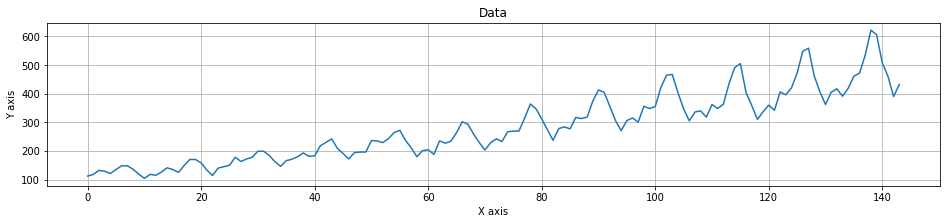

In [2]:
fileName = 'datosT1P2.txt'
data = np.loadtxt(fileName)

fig = plt.figure(0,(16,3))
plt.plot(data[:,0],data[:,1])
plt.title('Data')
plt.xlabel('X axis')
plt.ylabel('Y axis')
plt.grid()
plt.show(fig)

Total data: 144
Train data: 108
Test data : 36


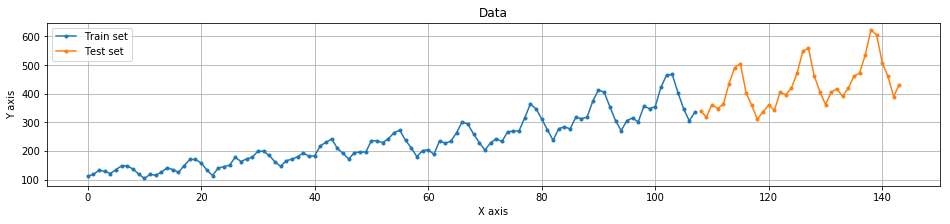

0.0 107.0
112.0 336.0


In [3]:

nData = data.shape[0]
nTrain = int(np.ceil(0.75*nData))

print('Total data: %i\nTrain data: %i\nTest data : %i' %(nData, nTrain, nData-nTrain))

train_set = data[0:nTrain,:]
test_set  = data[nTrain:,:]

fig = plt.figure(0,(16,3))
plt.plot(train_set[:,0],train_set[:,1],'.-')
plt.plot(test_set[:,0],test_set[:,1],'.-')
plt.title('Data')
plt.xlabel('X axis')
plt.ylabel('Y axis')
plt.legend(('Train set', 'Test set'))
plt.grid()
plt.show(fig)

print(train_set[0,0],train_set[-1,0])
print(train_set[0,1],train_set[-1,1])

In [4]:
import theano.tensor as tt

grade = 3

k = np.linspace(0,grade,grade+1)
X = train_set[:,0]
print('X shape: %s' % X.shape)

Y = train_set[:,1]
print('Y shape: %s' % Y.shape)


basic_model = pm.Model()

with basic_model:
    # Priors for unknown model parameters
    theta = pm.Normal('theta', mu=0, sd=100, shape = 4)
    # theta3 = pm.Normal('theta3', mu=0, sd=100)
    # sigma = pm.HalfNormal('sigma', sd=10)
    sigma = pm.HalfNormal('sigma_y', sd=200)

    # Expected value of outcome
    mu_obs = theta[3]+theta[2]*X#+theta[1]*np.power(X,2)#+theta[0]*np.power(X,3)
    # mu_obs = np.sum(np.dot(theta,X_aux),axis = 1)
    print('mu_obs shape: %s'% mu_obs.shape)
        
    # Model
    Y_obs = pm.Normal('Y_obs', mu=mu_obs, sd=sigma, observed=Y)
    
    ## sample using MEtropolis
    # step = pm.Metropolis()
    # trace = pm.sample(10000, step)

map_estimate = pm.find_MAP(model=basic_model)

print(map_estimate)

X shape: 108
Y shape: 108
mu_obs shape: Shape.0


logp = -564.92, ||grad|| = 0.91504: 100%|██████████| 36/36 [00:00<00:00, 1806.16it/s]  

{'theta': array([  0.        ,   0.        ,   2.49878632,  97.10382693]), 'sigma_y_log__': array(3.5513407344267454), 'sigma_y': array(34.86002420452199)}


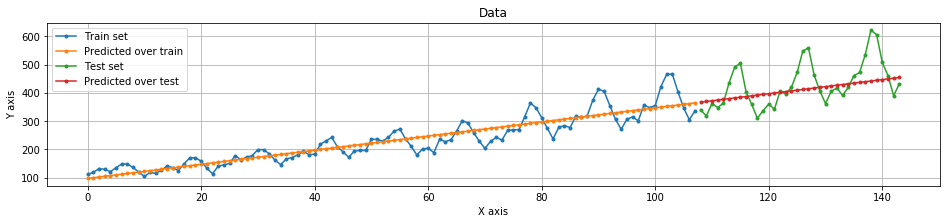

In [5]:
# theta = [float(map_estimate['theta1']),float(map_estimate['theta0'])]
theta = map_estimate['theta']
# theta = [float(map_estimate['theta3']), float(map_estimate['theta2']), float(map_estimate['theta1']),float(map_estimate['theta0'])]

X_test = test_set[:,0]
Y_test = test_set[:,1]

Y_train_hat_pol = np.polyval(theta,X)
Y_hat_pol = np.polyval(theta,X_test)

fig = plt.figure(0,(16,3))
plt.plot(X,Y,'.-')
plt.plot(X,Y_train_hat_pol,'.-')
plt.plot(X_test,Y_test,'.-')
plt.plot(X_test,Y_hat_pol ,'.-')
plt.title('Data')
plt.xlabel('X axis')
plt.ylabel('Y axis')
plt.legend(('Train set', 'Predicted over train', 'Test set', 'Predicted over test'))
plt.grid()
plt.savefig('final.pdf', format = 'pdf', bbox_inches = 'tight')
plt.show(fig)

In [6]:
def f_pol_sin(x,a,b_list):
    out = np.polyval(a,x)
    
    for b in b_list:
        out += b[0]*np.sin(b[1]*x+b[2])*np.exp(b[3]*x)
        
    return out

In [7]:
numberOfBasis = 1
theta_sin_val = [np.asarray([0,0,0,0])]
mu_vector =  np.asarray([11, 1332, 98, 0.01])
sd_vector =  np.asarray([1, 1, 1, 0.001])
for i in range(numberOfBasis):
    with basic_model:
        # Priors for unknown model parameters
        theta_sin = pm.Normal('theta{}'.format(i), mu=mu_vector, sd=sd_vector, shape = 4)
        # theta3 = pm.Normal('theta3', mu=0, sd=100)
        # sigma = pm.HalfNormal('sigma', sd=10)
        sigma = pm.HalfNormal('sigma_y{}'.format(i), sd=200)

        # Expected value of outcome
        mu_obs = f_pol_sin(X,theta,theta_sin_val) + theta_sin[0]*tt.sin(theta_sin[1]*X + theta_sin[2])*tt.exp(theta_sin[3]*X)
        # mu_obs = np.sum(np.dot(theta,X_aux),axis = 1)
        print('mu_obs shape: %s'% mu_obs.shape)

        # Model
        Y_obs = pm.Normal('Y_obs{}'.format(i), mu=mu_obs, sd=sigma, observed=Y)

        ## sample using MEtropolis
        # step = pm.Metropolis()
        # trace = pm.sample(10000, step)

        start = pm.find_MAP()
        step = pm.Metropolis()
        trace = pm.sample(5000, step, start=start)
        
        print(pm.waic(trace))
        print(pm.loo(trace))

#     print(map_estimate)

mu_obs shape: Shape.0


logp = -1,071.9, ||grad|| = 7.2713: 100%|██████████| 349/349 [00:00<00:00, 1243.74it/s]  
100%|██████████| 5500/5500 [00:05<00:00, 1078.71it/s]
/home/lerkoah/anaconda3/lib/python3.6/site-packages/pymc3/stats.py:220: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


WAIC_r(WAIC=2066.9919545350426, WAIC_se=26.744527126747254, p_WAIC=6.8981459841614514)


/home/lerkoah/anaconda3/lib/python3.6/site-packages/pymc3/stats.py:285: UserWarning: Estimated shape parameter of Pareto distribution is
        greater than 0.7 for one or more samples.
        You should consider using a more robust model, this is
        because importance sampling is less likely to work well if the marginal
        posterior and LOO posterior are very different. This is more likely to
        happen with a non-robust model and highly influential observations.
  happen with a non-robust model and highly influential observations.""")


LOO_r(LOO=2068.5277347304618, LOO_se=26.933317660940546, p_LOO=7.6660360818709705)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1f7dee9518>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f1f7de07438>]], dtype=object)

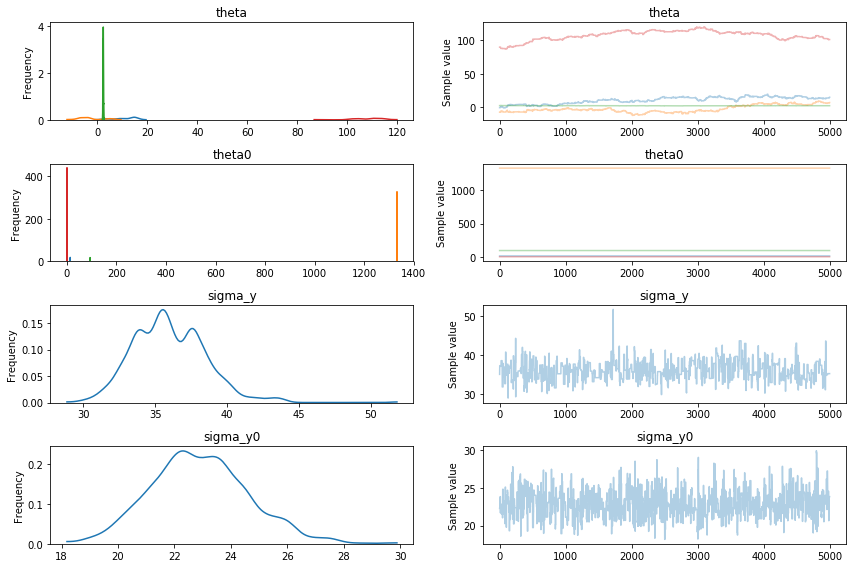

In [8]:
pm.traceplot(trace)

In [9]:
pm.summary(trace)


theta:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  10.663           4.831            0.479            [1.282, 17.246]
  -2.372           5.206            0.517            [-10.208, 7.428]
  2.364            0.110            0.010            [2.160, 2.589]
  107.094          7.083            0.706            [90.673, 118.579]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  1.282          7.275          11.634         14.760         17.246
  -10.646        -6.403         -3.779         2.559          7.323
  2.170          2.287          2.360          2.422          2.604
  89.578         103.077        109.091        112.418        118.116


theta0:

  Mean             SD               MC Error         95% HPD interval
  ------------------------------------------------------

In [10]:
theta_sin_val.append(np.mean(trace['theta0'], axis=0))
theta_sin_val

[array([0, 0, 0, 0]),
 array([  1.32804905e+01,   1.33254965e+03,   9.35954670e+01,
          1.24513591e-02])]

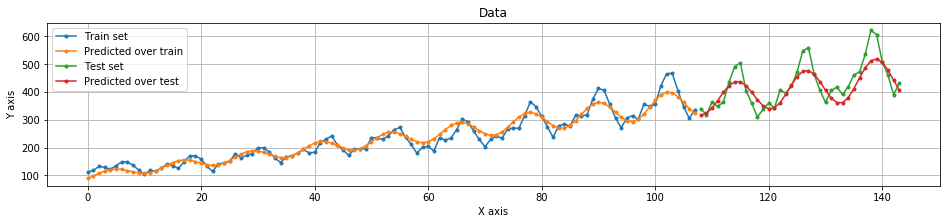

In [11]:
X_test = test_set[:,0]
Y_test = test_set[:,1]

Y_train_hat_polsin = f_pol_sin(X,theta,theta_sin_val)
Y_hat_polsin = f_pol_sin(X_test,theta,theta_sin_val)

fig = plt.figure(0,(16,3))
plt.plot(X,Y,'.-')
plt.plot(X,Y_train_hat_polsin,'.-')
plt.plot(X_test,Y_test,'.-')
plt.plot(X_test,Y_hat_polsin ,'.-')
plt.title('Data')
plt.xlabel('X axis')
plt.ylabel('Y axis')
plt.legend(('Train set', 'Predicted over train', 'Test set', 'Predicted over test'))
plt.grid()
plt.savefig('final.pdf', format = 'pdf', bbox_inches = 'tight')
plt.show(fig)